In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from tqdm.notebook import tqdm, trange
import seaborn as sns
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import matplotlib

sc.settings.verbosity = 3


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import utils as my_utils

In [4]:
# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_semi_final.h5ad"
adata_semi = sc.read_h5ad(adata_path)

# Read single-cell data
adata_path = data_dir / "metadata" / f"combined_flowjo.h5ad"
adata_manual = sc.read_h5ad(adata_path)

C:\Users\thu71\Anaconda3\envs\traj\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [5]:
# rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
#                'Stroma Vimentin+': 'Stroma'
#               }
rename_dict = {'Activated B': 'B-cells', 'B-cells MZ': 'B-cells', 'CD38+': 'Stroma',
       'Cytotoxic T-cells': 'T-cells', 'DZ B-cells': 'B-cells', 'Exhausted T-cells': 'T-cells', 
               'FDC': 'Other',
       'Helper T-cells': 'T-cells', 'LZ B-cells': 'B-cells',
       'Stroma Vimentin+':  'Stroma', 'TFH': 'T-cells', 'Treg': 'T-cells', 'myeloid-derived cells': 'Other'
              }


# Rename a cluster
adata_semi.obs["cluster"] = adata_semi.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')

In [6]:
# rename_dict = {'Activated B':'B-cells',  'B-cells MZ':'B-cells', 'CD38+': 'Stroma', 
#                'Stroma Vimentin+': 'Stroma'
#               }

rename_dict = {'Cytotoxic T-cells':  'T cells', 
               'DZ B-cells': 'B cells', 
               'Exhausted T-cells':  'T cells',
               'FDCs': 'Other', 
               'Follicular CD8+ T-cells':  'T cells', 
               'Follicular Helper T-cells':  'T cells',
               'GC B-cells': 'B cells', 
               'Helper T-cells':  'T cells',
               'LZ B-cells':'B cells', 
               'Plasma Cells': 'Other',
               'Regulatory T-cells': 'T cells',
              }


# Rename a cluster
adata_manual.obs["cluster"] = adata_manual.obs["Phenotype"].map(lambda x: rename_dict.get(x, x)).astype('category')


In [7]:
import sklearn.metrics.cluster


In [8]:
df_semi = adata_semi.obs
df_manual = adata_manual.obs
df_manual.columns = ['Donor', 'Phenotype', 'ROI', 'Cell', 'index', 'Dataset', 'cluster'] 
df_all = pd.merge(df_semi, df_manual, on=['Dataset', 'ROI', 'Cell'], how='right', suffixes=('_semi', '_manual'),)

In [9]:
np.unique(df_all.cluster_manual)

array(['B cells', 'Other', 'Stromal cells', 'T cells'], dtype=object)

# Per round clustering 

In [10]:
subset = ['B cells', 'DZ B-cells',
       'GC B-cells', 'LZ B-cells', 
       ]

df_all = df_all[df_all.Phenotype_manual.isin(subset)]

In [11]:
import numpy as np
from sklearn import metrics
from scipy.optimize import linear_sum_assignment

def purity(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)

    # Find optimal one-to-one mapping between cluster labels and true labels
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)

    # Return cluster accuracy
    return contingency_matrix[row_ind, col_ind].sum() / np.sum(contingency_matrix)

In [12]:
rand_score = {}

0.04118118666550846


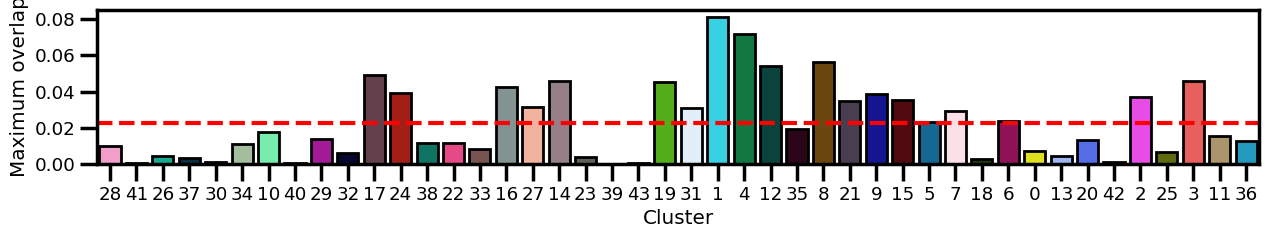

In [35]:
# Get contigency matrix
semi_name = 'leiden'
c_matrix = sklearn.metrics.cluster.contingency_matrix(df_all[semi_name].tolist(), df_all.cluster_manual.tolist())
# purity = metrics.rand_score(df_all.cluster_manual.tolist(), df_all[semi_name].tolist(),
#                                              average_method='max')
purity = metrics.rand_score(df_all.cluster_manual.tolist(), df_all[semi_name].tolist(),)
rand_score['Round 1'] = purity
print(purity)

# Get colors
cluster_label_order = adata_semi.uns[f'dendrogram_{semi_name}']['categories_ordered']
index_order = adata_semi.uns[f'dendrogram_{semi_name}']['categories_idx_ordered']

colors = adata_semi.uns[f"{semi_name}_colors"]

# Normalize per manual
df_c_matrix = pd.crosstab(df_all[semi_name], df_all.cluster_manual)
df_c_matrix = df_c_matrix.div(df_c_matrix.sum(axis=0), axis=1)

# Get max per row
df_max = df_c_matrix.max(axis=1).reset_index()
df_max.columns=['Cluster', 'Maximum overlap']

# Plot 
with sns.plotting_context('poster', font_scale=0.6):
    fig, ax= plt.subplots(figsize=(15,2))
    sns.barplot(data=df_max, x='Cluster', y='Maximum overlap', ax=ax, 
                order=cluster_label_order, palette=colors[index_order], edgecolor='k')
    ax.axhline(y=df_max['Maximum overlap'].mean(), c='red', linestyle='dashed', label="horizontal")


0.06220975619296923


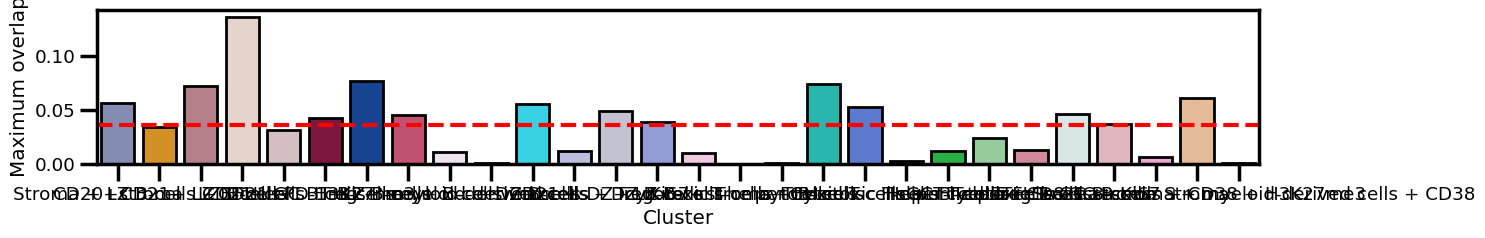

In [36]:
# Get contigency matrix
semi_name = 'Phenotype_r1'
c_matrix = sklearn.metrics.cluster.contingency_matrix(df_all[semi_name].tolist(), df_all.cluster_manual.tolist())
# purity = metrics.normalized_mutual_info_score(df_all.cluster_manual.tolist(), df_all[semi_name].tolist(),
#                                              average_method='max')
purity = metrics.rand_score(df_all.cluster_manual.tolist(), df_all[semi_name].tolist(),)
rand_score['Round 2'] = purity

print(purity)

# Get colors
cluster_label_order = adata_semi.uns[f'dendrogram_{semi_name}']['categories_ordered']
index_order = adata_semi.uns[f'dendrogram_{semi_name}']['categories_idx_ordered']

colors = adata_semi.uns[f"{semi_name}_colors"]

# Normalize per manual
df_c_matrix = pd.crosstab(df_all[semi_name], df_all.cluster_manual)
df_c_matrix = df_c_matrix.div(df_c_matrix.sum(axis=0), axis=1)

# Get max per row
df_max = df_c_matrix.max(axis=1).reset_index()
df_max.columns=['Cluster', 'Maximum overlap']

# Plot 
with sns.plotting_context('poster', font_scale=0.6):
    fig, ax= plt.subplots(figsize=(15,2))
    sns.barplot(data=df_max, x='Cluster', y='Maximum overlap', ax=ax, 
                order=cluster_label_order, palette=colors[index_order], edgecolor='k')
    ax.axhline(y=df_max['Maximum overlap'].mean(), c='red', linestyle='dashed', label="horizontal")


0.12260182420938998


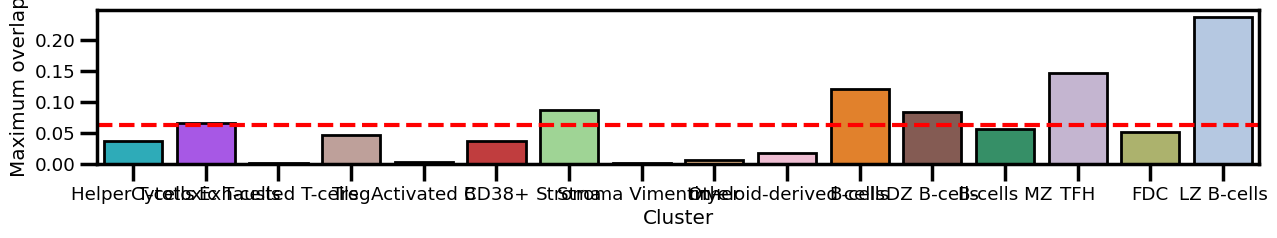

In [37]:
# Get contigency matrix
semi_name = 'Phenotype'
c_matrix = sklearn.metrics.cluster.contingency_matrix(df_all[semi_name+'_semi'].tolist(), df_all.cluster_manual.tolist())
# purity = metrics.normalized_mutual_info_score(df_all.cluster_manual.tolist(), df_all[semi_name+'_semi'].tolist(),
#                                              average_method='max')
purity = metrics.rand_score(df_all.cluster_manual.tolist(), df_all[semi_name+'_semi'].tolist())
rand_score['Round 3'] = purity
print(purity)

# Get colors
cluster_label_order = adata_semi.uns[f'dendrogram_{semi_name}']['categories_ordered']
index_order = adata_semi.uns[f'dendrogram_{semi_name}']['categories_idx_ordered']

colors = adata_semi.uns[f"{semi_name}_colors"]

# Normalize per manual
df_c_matrix = pd.crosstab(df_all[semi_name+'_semi'], df_all.cluster_manual)
df_c_matrix = df_c_matrix.div(df_c_matrix.sum(axis=0), axis=1)

# Get max per row
df_max = df_c_matrix.max(axis=1).reset_index()
df_max.columns=['Cluster', 'Maximum overlap']

# Plot 
with sns.plotting_context('poster', font_scale=0.6):
    fig, ax= plt.subplots(figsize=(15,2))
    sns.barplot(data=df_max, x='Cluster', y='Maximum overlap', ax=ax, 
                order=cluster_label_order, palette=colors[index_order], edgecolor='k')
    ax.axhline(y=df_max['Maximum overlap'].mean(), c='red', linestyle='dashed', label="horizontal")


0.3622175539247531


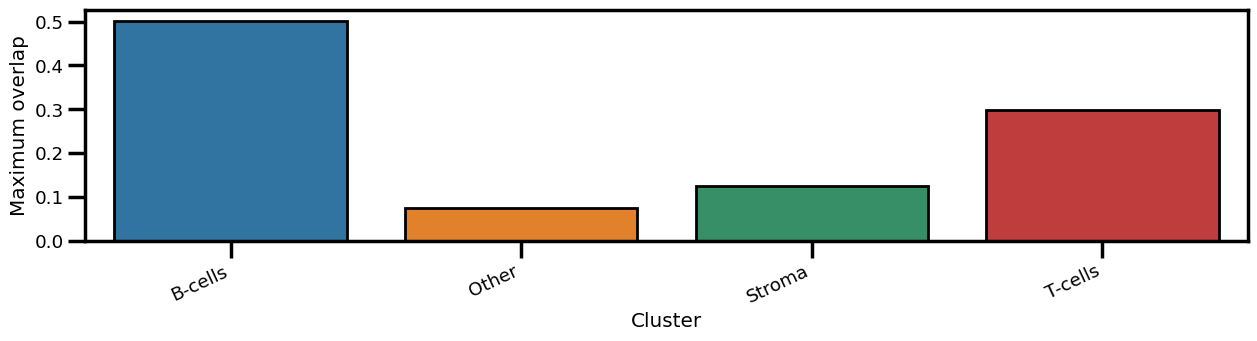

In [216]:
# Get contigency matrix
semi_name = 'cluster'
c_matrix = sklearn.metrics.cluster.contingency_matrix(df_all[semi_name+'_semi'].tolist(), df_all.cluster_manual.tolist())
# purity = metrics.normalized_mutual_info_score(df_all.cluster_manual.tolist(), df_all[semi_name+'_semi'].tolist(),
#                                              average_method='max')
purity = metrics.rand_score(df_all.cluster_manual.tolist(), df_all[semi_name+'_semi'].tolist())
rand_score['Round 4'] = purity
print(purity)

# Get colors

colors = adata_semi.uns[f"Phenotype_colors"]
# labels = adata_semi.obs[semi_name].cat.categories.tolist()

# colors_rgb = []
# for color in colors:
#     colors_rgb.append(matplotlib.colors.hex2color(color))
# colors_rgb = np.array(colors_rgb) * 255
# colors_rgb = colors_rgb.astype(np.uint8)

# colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

# Normalize per manual
df_c_matrix = pd.crosstab(df_all[semi_name+'_semi'], df_all.cluster_manual)
df_c_matrix = df_c_matrix.div(df_c_matrix.sum(axis=0), axis=1)

# Get max per row
df_max = df_c_matrix.max(axis=1).reset_index()
df_max.columns=['Cluster', 'Maximum overlap']

# Plot 
with sns.plotting_context('poster', font_scale=0.6):
    fig, ax= plt.subplots(figsize=(15,3))
    sns.barplot(data=df_max, x='Cluster', y='Maximum overlap', ax=ax, palette=colors, edgecolor='k')
    plt.xticks(rotation = 25, ha='right')

In [224]:
df_score = pd.DataFrame.from_dict(rand_score, orient='index').reset_index()
df_score.columns = ['Clustering', 'Rand Score']

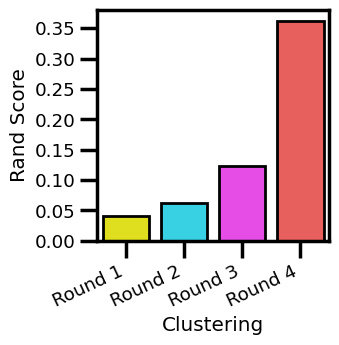

In [226]:
# Plot 
with sns.plotting_context('poster', font_scale=0.6):
    fig, ax= plt.subplots(figsize=(3,3))
    sns.barplot(data=df_score, x='Clustering', y='Rand Score', ax=ax, palette=colors, edgecolor='k')
    plt.xticks(rotation = 25, ha='right')

# Final clustering metrics 

In [11]:
import sklearn.metrics.cluster

c_matrix = sklearn.metrics.cluster.contingency_matrix(df_all.cluster_semi.tolist(), df_all.cluster_manual.tolist())

In [15]:
df_c_matrix = pd.crosstab(df_all.cluster_semi, df_all.cluster_manual)
df_c_matrix = df_c_matrix.div(df_c_matrix.sum(axis=1), axis=0)

In [17]:
df_c_matrix.sum(axis=1)

cluster_semi
B-cells                  1.0
Cytotoxic T-cells        1.0
DZ B-cells               1.0
Exhausted T-cells        1.0
FDC                      1.0
Helper T-cells           1.0
LZ B-cells               1.0
Other                    1.0
Stroma                   1.0
TFH                      1.0
Treg                     1.0
myeloid-derived cells    1.0
dtype: float64

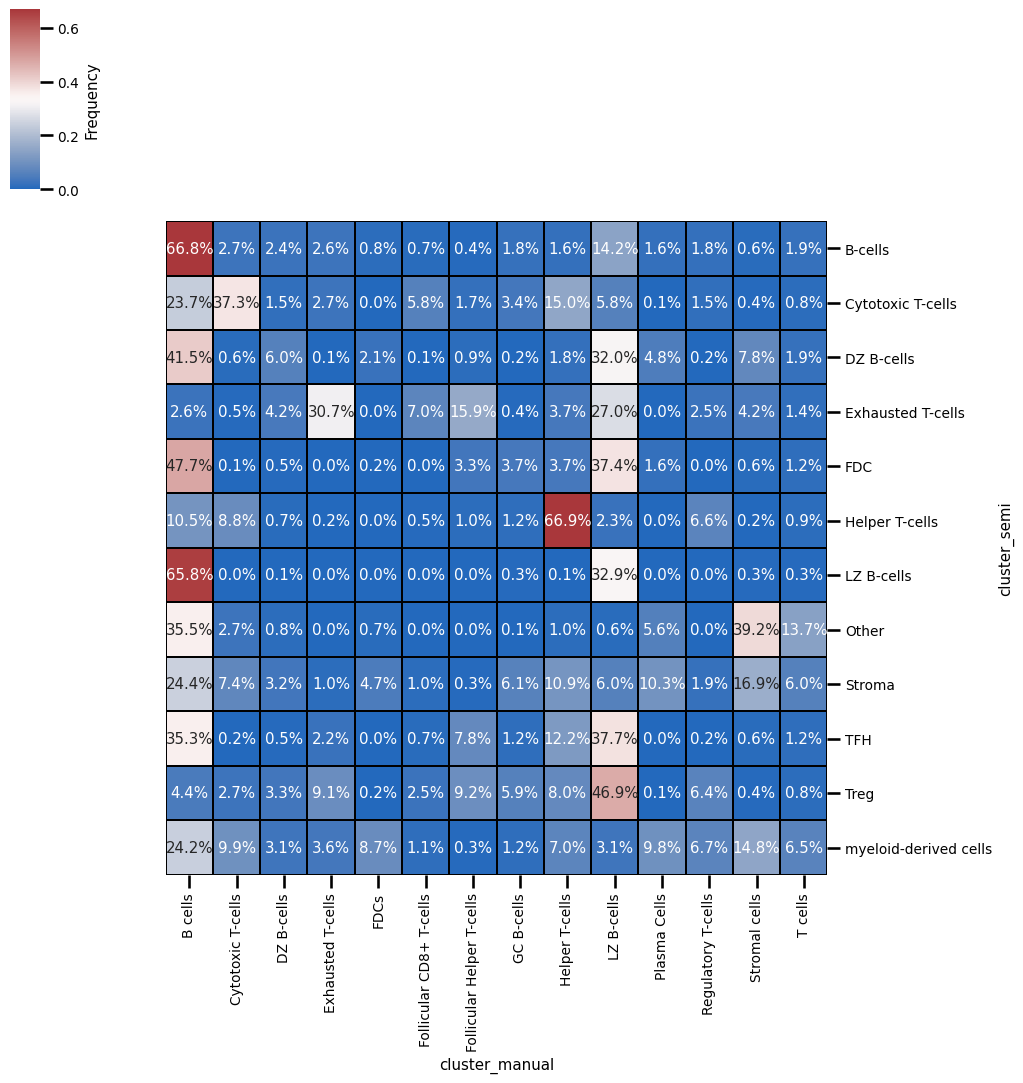

In [18]:
kws = dict(cbar_kws=dict(label='Frequency'))
with sns.plotting_context('talk', font_scale=0.6):
    g = sns.clustermap(df_c_matrix, cmap="vlag", row_cluster=False, col_cluster=False, linewidth=0.01, dendrogram_ratio=0.15,
                            cbar_pos=(-0.02, 0.9, 0.03, 0.18), linecolor='k', annot=True,  fmt=".1%",
                           **kws)